In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import KFold, LeaveOneGroupOut, train_test_split

In [2]:
SEED = 42
N_JOBS = -1

## Load data

In [3]:
data = pd.read_csv("../data/data.csv")

X = data.drop(["timestamp", "label", "subject"], axis=1)
groups = data["subject"]
y = data["label"]

## Classifiers

In [4]:
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


def classify(split_name, X_train, y_train, X_test, y_test):
    classifiers_names = [
        "Nearest Neighbors",
        "Linear SVM",
        "RBF SVM",
        "Gaussian Process",
        "Decision Tree",
        "Random Forest",
        "Neural Net",
        "AdaBoost",
        "Naive Bayes",
        "Gradient Boosting",
    ]

    classifiers = [
        KNeighborsClassifier(n_neighbors=5, n_jobs=N_JOBS),
        SVC(kernel="linear", random_state=SEED),
        SVC(kernel="rbf", random_state=SEED),
        GaussianProcessClassifier(kernel=1.0 * RBF(1.0), n_jobs=N_JOBS, random_state=SEED),
        DecisionTreeClassifier(random_state=SEED),
        RandomForestClassifier(n_jobs=N_JOBS, random_state=SEED),
        MLPClassifier(max_iter=1000, random_state=SEED),
        AdaBoostClassifier(random_state=SEED),
        GaussianNB(),
        GradientBoostingClassifier(random_state=SEED),
    ]

    df = pd.DataFrame(columns=["classifier", "split_method", "accuracy", "precision", "recall", "f1"])
    for name, clf in zip(classifiers_names, classifiers):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        precision, recall, f_score, _ = precision_recall_fscore_support(
            y_test, y_pred, average="weighted", zero_division=0
        )
        df.loc[len(df)] = [name, split_name, acc, precision, recall, f_score]

    return df

# Train-Test Split
## Leave One Subject Out

In [5]:
logo = LeaveOneGroupOut()
logo_results = pd.DataFrame()
for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    df = classify("logo", X_train, y_train, X_test, y_test)
    logo_results = pd.concat([logo_results, df], ignore_index=True)

logo_results = (
    logo_results.groupby(by=["classifier", "split_method"])
    .mean()
    .reset_index()
    .sort_values("accuracy", ascending=False)
)
logo_results

,classifier,split_method,accuracy,precision,recall,f1
5,Naive Bayes,logo,0.854848,0.875413,0.854848,0.848197
9,Random Forest,logo,0.799134,0.853291,0.799134,0.769756
3,Gradient Boosting,logo,0.692643,0.707600,0.692643,0.618351
1,Decision Tree,logo,0.655792,0.715480,0.655792,0.596046
4,Linear SVM,logo,0.549699,0.572592,0.549699,0.453815
0,AdaBoost,logo,0.512616,0.524618,0.512616,0.431654
7,Neural Net,logo,0.477500,0.499053,0.477500,0.396058
2,Gaussian Process,logo,0.462975,0.556742,0.462975,0.366532
6,Nearest Neighbors,logo,0.414227,0.381629,0.414227,0.340757
8,RBF SVM,logo,0.361917,0.340893,0.361917,0.298057


## 10-Fold

In [6]:
kf_10 = KFold(n_splits=10, shuffle=True, random_state=SEED)
kf_10_results = pd.DataFrame()
for train_index, test_index in kf_10.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    df = classify("10-fold", X_train, y_train, X_test, y_test)
    kf_10_results = pd.concat([kf_10_results, df], ignore_index=True)

kf_10_results = (
    kf_10_results.groupby(by=["classifier", "split_method"])
    .mean()
    .reset_index()
    .sort_values("accuracy", ascending=False)
)
kf_10_results

,classifier,split_method,accuracy,precision,recall,f1
1,Decision Tree,10-fold,0.984480,0.985181,0.984480,0.984472
3,Gradient Boosting,10-fold,0.979285,0.980505,0.979285,0.979313
9,Random Forest,10-fold,0.976721,0.977684,0.976721,0.976725
5,Naive Bayes,10-fold,0.968961,0.970145,0.968961,0.968995
2,Gaussian Process,10-fold,0.963765,0.965963,0.963765,0.963965
0,AdaBoost,10-fold,0.963698,0.965505,0.963698,0.963383
6,Nearest Neighbors,10-fold,0.961066,0.964231,0.961066,0.961022
4,Linear SVM,10-fold,0.958300,0.961373,0.958300,0.958219
7,Neural Net,10-fold,0.958232,0.960189,0.958232,0.957567
8,RBF SVM,10-fold,0.916734,0.928588,0.916734,0.914150


## Compare results

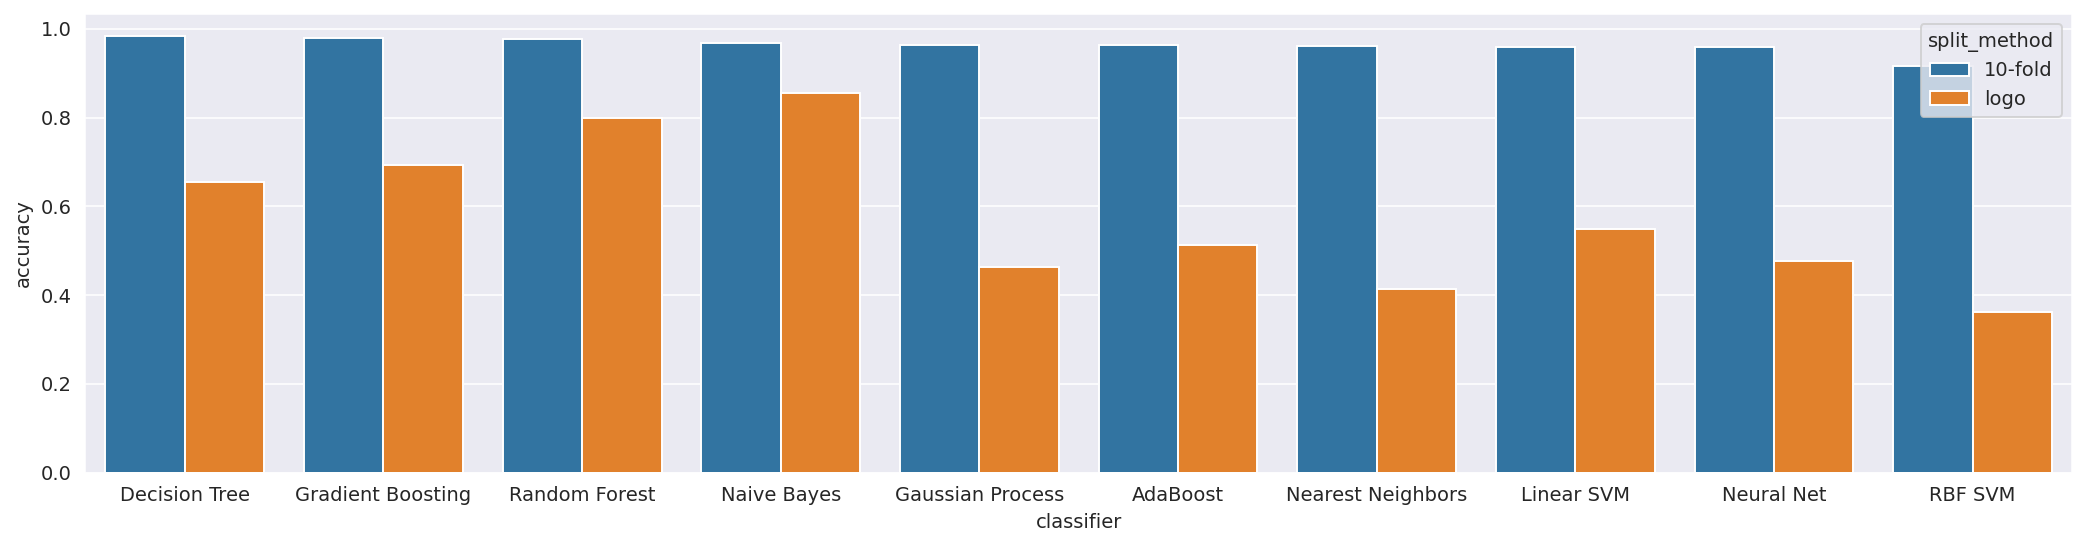

In [7]:
cv_results = pd.concat([kf_10_results, logo_results])
fig, ax = plt.subplots(figsize=(15, 4), dpi=140)
sns.barplot(x="classifier", y="accuracy", hue="split_method", data=cv_results, ax=ax)
fig.tight_layout()
plt.show()

# Feature Subset

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED, stratify=y)

In [9]:
clf = DecisionTreeClassifier(random_state=SEED)
clf.fit(X, y)
y_pred = clf.predict(X_test)
print("Accuracy =", accuracy_score(y_test, y_pred))

Accuracy = 1.0


In [10]:
print("Tree depth =", clf.get_depth())

Tree depth = 5


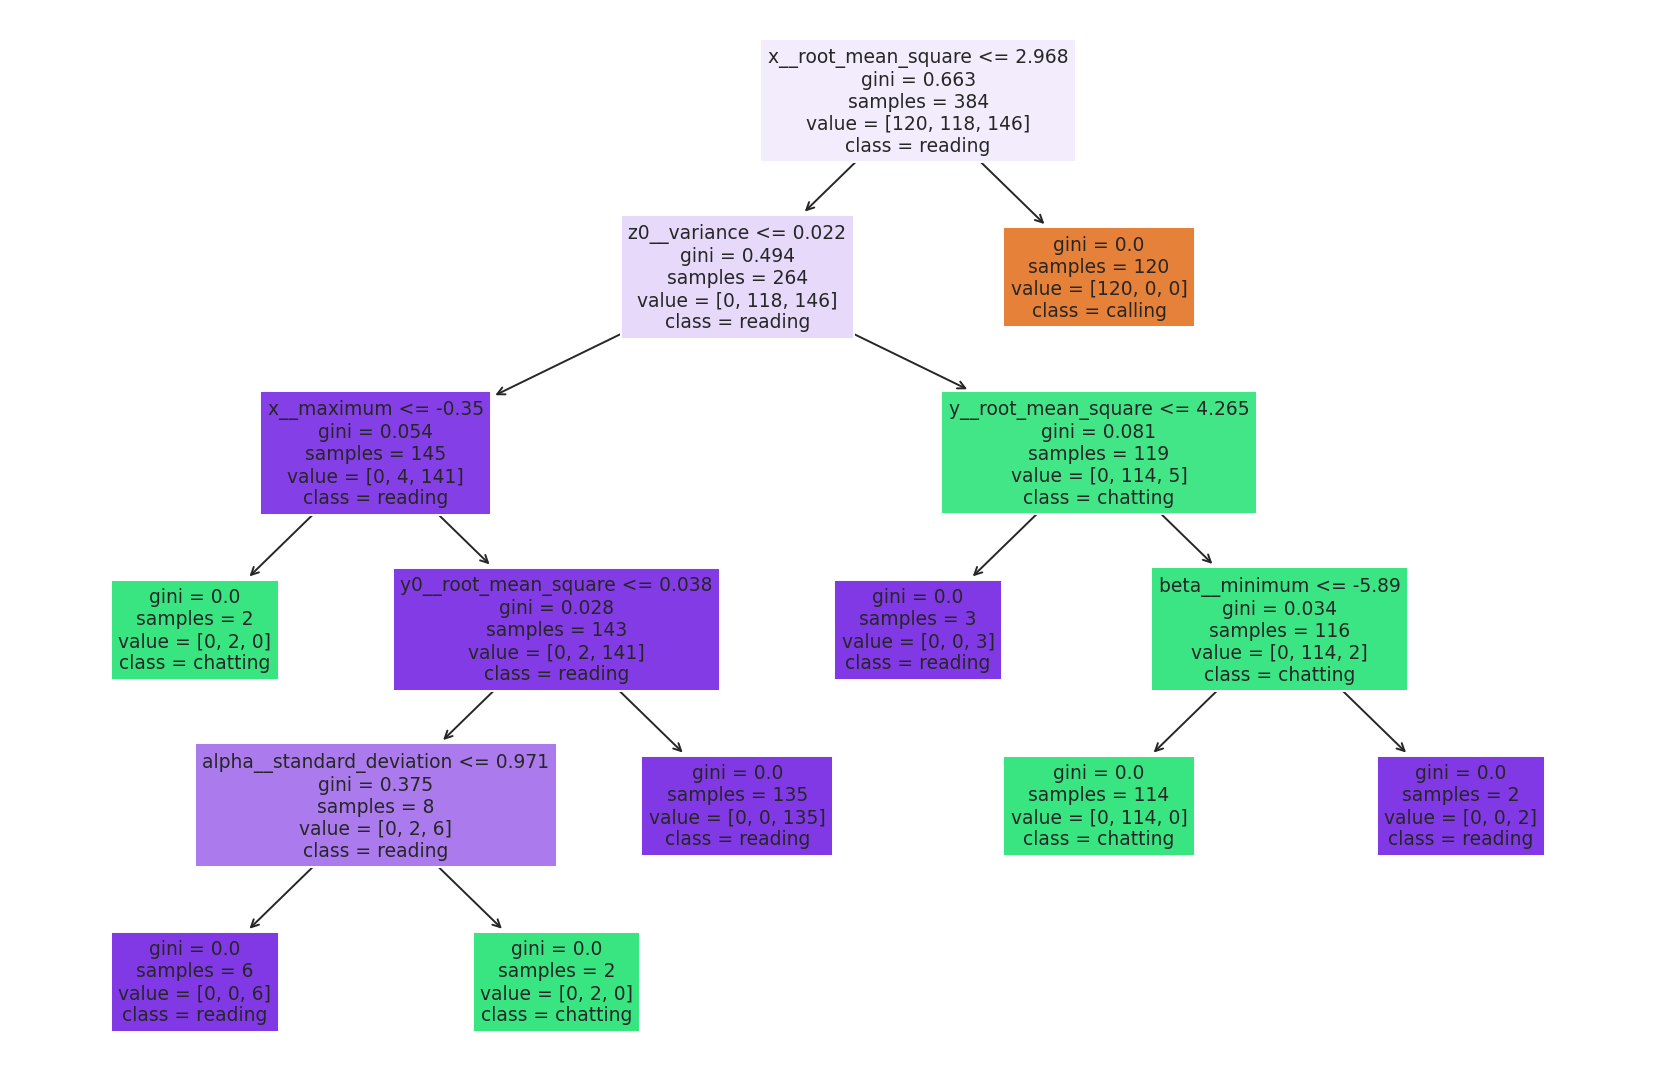

In [11]:
fig, ax = plt.subplots(figsize=(15, 10), dpi=140)
_ = tree.plot_tree(
    clf, ax=ax, feature_names=X_train.columns, class_names=["calling", "chatting", "reading"], filled=True
)

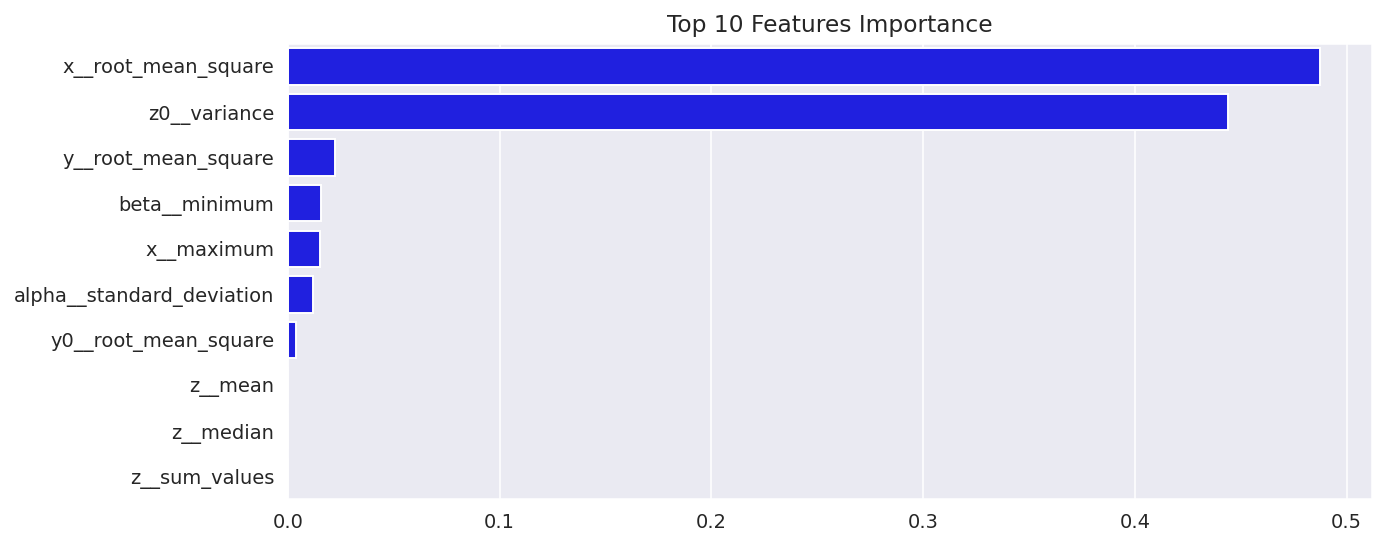

In [12]:
features_idx = (-clf.feature_importances_).argsort()[:10]
fig, ax = plt.subplots(figsize=(10, 4), dpi=140)
sns.barplot(x=clf.feature_importances_[features_idx], y=X_train.columns[features_idx], ax=ax, orient="h", color="b")
ax.set_title("Top 10 Features Importance")
fig.tight_layout()
plt.show()

In [13]:
selected_features = ["x__root_mean_square", "z0__variance"]

In [14]:
classify("stratified_train_test", X_train[selected_features], y_train, X_test[selected_features], y_test).drop(
    columns="split_method"
).sort_values("accuracy", ascending=False)

,classifier,accuracy,precision,recall,f1
0,Nearest Neighbors,0.961039,0.961340,0.961039,0.960955
4,Decision Tree,0.948052,0.949385,0.948052,0.947788
5,Random Forest,0.948052,0.949385,0.948052,0.947788
8,Naive Bayes,0.948052,0.954349,0.948052,0.947366
9,Gradient Boosting,0.948052,0.949385,0.948052,0.947788
6,Neural Net,0.935065,0.938080,0.935065,0.934497
3,Gaussian Process,0.922078,0.927351,0.922078,0.921050
1,Linear SVM,0.896104,0.907359,0.896104,0.893553
2,RBF SVM,0.883117,0.910800,0.883117,0.877481
7,AdaBoost,0.883117,0.910800,0.883117,0.877481



# Recursive Feature Elimination

In [15]:
classifiers_names = ["Linear SVM", "Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting"]

classifiers = [
    SVC(kernel="linear", random_state=SEED),
    DecisionTreeClassifier(random_state=SEED),
    RandomForestClassifier(n_jobs=N_JOBS, random_state=SEED),
    AdaBoostClassifier(random_state=SEED),
    GradientBoostingClassifier(random_state=SEED),
]

elimination_results = pd.DataFrame(columns=["classifier", "features"])

for name, clf in zip(classifiers_names, classifiers):
    selector = RFE(clf, n_features_to_select=5)
    selector = selector.fit(X_train, y_train)
    elimination_results.loc[len(elimination_results)] = [name, X_train.columns[selector.support_].to_list()]

## Get the most frequently selected features

In [16]:
rfe_features = [j for i in elimination_results["features"].to_list() for j in i]
features_frequency = {x: rfe_features.count(x) for x in rfe_features}
features_frequency = dict(sorted(features_frequency.items(), key=lambda item: item[1], reverse=True))
features_frequency

{'z__minimum': 4,
 'x__root_mean_square': 3,
 'z__maximum': 3,
 'z0__variance': 2,
 'z0__standard_deviation': 2,
 'z__root_mean_square': 2,
 'y0__sum_values': 1,
 'alpha__median': 1,
 'beta__standard_deviation': 1,
 'gamma__root_mean_square': 1,
 'y__mean': 1,
 'beta__length': 1,
 'beta__root_mean_square': 1,
 'y__root_mean_square': 1,
 'x__variance': 1}

In [17]:
elimination_results[elimination_results["classifier"] == "Decision Tree"]["features"].to_list()[0]

['z0__variance',
 'y__mean',
 'z__minimum',
 'beta__length',
 'beta__root_mean_square']